If not yet available some libraries and their python bindings have to be installed :<br>
- gmsh (best installed globally through package management system)
- python3 -m pip install pygmsh --user
- VTK (best installed globally through package management system)
- python3 -m pip install vtk --user

In [1]:
import numpy as np
from scipy import constants
import scipy.integrate
import scipy.special as func
from MeshedFields import *

# Create a meshed screen
we use a rather poor resolution to allow a quick test - not recommended for real application

In [6]:
mesh = MeshedField.CircularMesh(R=1.0, ratio=1.0, lcar=0.10)
pts = [np.array([p[0],p[1],5.0]) for p in mesh.points]
screen = MeshedField(pts, mesh.triangles)

print("%d points" % len(screen.points))
print("%d triangles" % len(screen.triangles))
area = screen.MeshArea()
normals = screen.MeshNormals()
average = np.sum(normals, axis=0)/screen.Np
print("total mesh area = %7.3f cm²" % (1.0e4*np.sum(area)))
print("screen normal = %s" % average)
print("bounding box :", screen.BoundingBox())

464 points
858 triangles
total mesh area = 31365.485 cm²
screen normal = [ 0.  0. -1.]
bounding box : ((-1.0, 1.0), (-1.0, 1.0), (5.0, 5.0))


### define the timing
The beam is assumed to start at the origin at t=0.

In [7]:
# time step
screen.dt = 2.0e-13
# all points use the same timing grid
screen.Nt = 400

screen.t0 = np.array([np.linalg.norm(p)/constants.c -200*screen.dt for p in screen.pos])

print("expected arrival time : ", 5.0/constants.c)
print(np.min(screen.t0))
print(np.max(screen.t0)+screen.Nt*screen.dt)
print(len(screen.t0))

expected arrival time :  1.6678204759907603e-08
1.66389561321e-08
1.70370981721e-08
858


### Write the file
It is assumed that the script was started from the scripts directory. The file should be created in the tests folder.
<br>
The file is included with the source code, so, the test case can be run without working this script.

In [17]:
filename="../tests/ForwardDiffractionRadiation.h5"
screen.WriteMeshedField(filename)

not writing ElMagField dataset


## Check the file after running the test

In [2]:
filename="../tests/ForwardDiffractionRadiation.h5"
computed = MeshedField.ReadMeshedField(filename)

print("%d points" % len(computed.points))
print("%d triangles" % len(computed.triangles))
area = computed.MeshArea()
normals = computed.MeshNormals()
average = np.sum(normals, axis=0)/computed.Np
print("total mesh area = %7.3f cm²" % (1.0e4*np.sum(area)))
print("screen normal = %s" % average)

corner points :  (464, 3)
triangles :  (858, 3)
Nt = 400   dt = 2e-13 
t0 :  (858,)
field :  (858, 400, 6)
464 points
858 triangles
total mesh area = 31365.485 cm²
screen normal = [ 0.  0. -1.]


In [3]:
area = computed.MeshArea()
S = [np.linalg.norm(computed.EnergyFlowVector(i)) for i in range(computed.Np)]
peak_index = np.argmax(S)
Pz = [computed.NormalEnergyFlow(i) for i in range(computed.Np)]

print("peak energy density = %.6f J/m²  index=%d" % (S[peak_index],peak_index))
print("total pulse energy = %.3f µJ" % (1e6*np.dot(area,Pz)))

peak energy density = 0.000000 J/m²  index=680
total pulse energy = 0.250 µJ


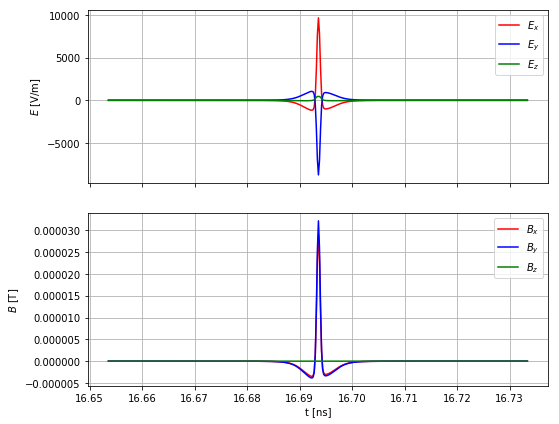

In [4]:
computed.ShowMeshedField(scalars=Pz,scalarTitle="Pz",highlight=[peak_index],showGrid=True)
computed.ShowFieldTrace(peak_index)

cell No. 274 pos=[ 0.22410517 -0.0268924   5.        ]
pointing vector S=[ -1.00364363e-08   1.20216367e-09   2.53882859e-07]


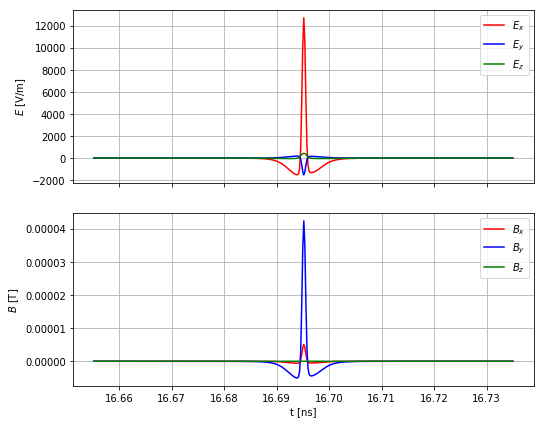

cell No. 560 pos=[ 0.73100309 -0.01287158  5.        ]
pointing vector S=[ -3.63085235e-10   6.04326056e-12   4.77171769e-08]


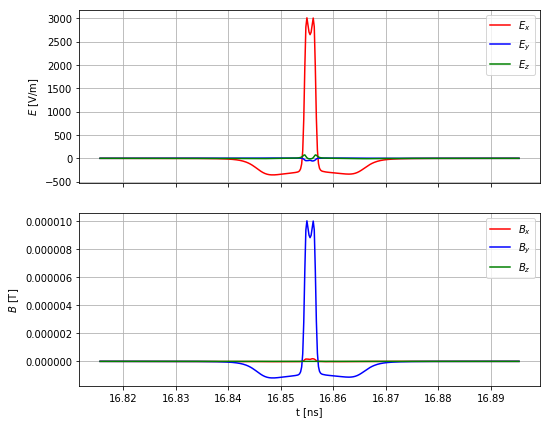

cell No. 793 pos=[ 0.94579814 -0.09816486  5.        ]
pointing vector S=[ -1.27128152e-10   1.30635290e-11   2.52307211e-08]


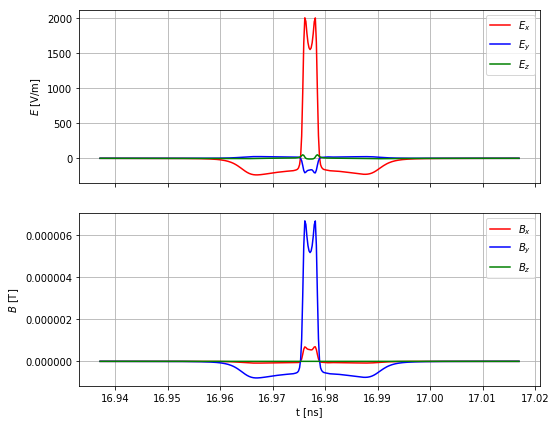

In [5]:
def pick(id):
    if id>0 and id<computed.Np:
        print("cell No. %d pos=%s" % (id,computed.pos[id]))
        print("pointing vector S=%s" % computed.EnergyFlowVector(id))
        computed.ShowFieldTrace(id)

computed.ShowMeshedField(scalars=Pz,scalarTitle="Pz",pickAction=pick,showGrid=False)